# Introduction

This notebook is inspired from [this post](https://www.splunk.com/en_us/blog/security/threat-hunting-for-dictionary-dga-with-peak.html). We build and train a Long Short Term Memory (LSTM) model based on a dataset made up of dictionary-based domains from [reversed malware](https://github.com/baderj/domain_generation_algorithms/tree/master) and legitimate domains downloaded from [Alexa 1M](https://github.com/mozilla/cipherscan/blob/master/top1m/top-1m.csv).

Due to some dataset removed as compared to the initial post, our dataset is a simplified one, limited to 300,000 domains from suppobox, nymaim2 and gozi.

# Install libraries

In [1]:
!pip install pandas numpy scikit-learn tensorflow[and-cuda]

Check GPU support for Tensorflow lib

In [2]:
import tensorflow as tf
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2025-12-30 07:01:41.965935: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/data/venv/lib/python3.13/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


2.20.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Check the dataset structure

Assuming the CSV file has a header "domain,label" and domains are labbeled "0" for legitimate and "1" for malicious

In [3]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, SpatialDropout1D
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Load the dataset
df = pd.read_csv('dataset.csv')

# Check the structure of your dataset
df.head()

,domain,label
0,potemquinuchrisdechrsua.com,1
1,vociferanturnec.com,1
2,magnumquodinteriorem.com,1
3,apostlibraryp.com,1
4,ppertheologispurgatorio.com,1


# Preprocess the domain names into a format that can be fed into the LSTM model

Convert each domain into a sequence of characters.

You can use a character-level tokenization approach for this purpose.

In [4]:
# Tokenization: Convert each domain into a list of characters (or n-grams if you prefer)
def domain_to_chars(domain):
    return list(domain)

df['domain_chars'] = df['domain'].apply(domain_to_chars)

# Optionally, check a sample to ensure proper preprocessing
df['domain_chars'].head()

0    [p, o, t, e, m, q, u, i, n, u, c, h, r, i, s, ...
1    [v, o, c, i, f, e, r, a, n, t, u, r, n, e, c, ...
2    [m, a, g, n, u, m, q, u, o, d, i, n, t, e, r, ...
3    [a, p, o, s, t, l, i, b, r, a, r, y, p, ., c, ...
4    [p, p, e, r, t, h, e, o, l, o, g, i, s, p, u, ...
Name: domain_chars, dtype: object

# Encode the characters into integers

(this is essential for LSTM, which works with numerical input).
You can create a mapping from characters to integers.

In [5]:
# Create a character-to-integer mapping
chars = set(''.join(df['domain']))  # Set of all characters
char_to_int = {char: idx+1 for idx, char in enumerate(sorted(chars))}  # +1 because index 0 will be reserved for padding

# Apply encoding to the domains
df['domain_int'] = df['domain_chars'].apply(lambda x: [char_to_int[char] for char in x])

# Example of how it looks
df['domain_int'].head()

0    [59, 58, 63, 48, 56, 60, 64, 52, 57, 64, 46, 5...
1    [65, 58, 46, 52, 49, 48, 61, 44, 57, 63, 64, 6...
2    [56, 44, 50, 57, 64, 56, 60, 64, 58, 47, 52, 5...
3    [44, 59, 58, 62, 63, 55, 52, 45, 61, 44, 61, 6...
4    [59, 59, 48, 61, 63, 51, 48, 58, 55, 58, 50, 5...
Name: domain_int, dtype: object

# Pad sequences so that all input sequences have the same length
(LSTM requires fixed-length sequences).

In [6]:
# Pad the sequences to a fixed length (e.g., 50 characters)
MAX_LENGTH = 75  # Adjust based on the length of your longest domain name
X = pad_sequences(df['domain_int'], maxlen=MAX_LENGTH)

# Labels
y = df['label'].values

# Split the data into training and testing sets

In [7]:
# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the LSTM model

In [8]:
# Build the LSTM model
model = Sequential()
model.add(Embedding(input_dim=len(char_to_int)+1, output_dim=128, input_length=MAX_LENGTH))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print the model summary
model.summary()

/data/venv/lib/python3.13/site-packages/keras/src/layers/core/embedding.py:100: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
I0000 00:00:1767074521.083533    2717 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4367 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1660 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

# Train the model

In [9]:
# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/5
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 994s 131ms/step - accuracy: 0.9316 - loss: 0.1768 - val_accuracy: 0.9567 - val_loss: 0.1189
Epoch 2/5
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 962s 128ms/step - accuracy: 0.9607 - loss: 0.1061 - val_accuracy: 0.9679 - val_loss: 0.0869
Epoch 3/5
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 965s 129ms/step - accuracy: 0.9672 - loss: 0.0878 - val_accuracy: 0.9726 - val_loss: 0.0727
Epoch 4/5
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 995s 133ms/step - accuracy: 0.9711 - loss: 0.0777 - val_accuracy: 0.9760 - val_loss: 0.0659
Epoch 5/5
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 1033s 138ms/step - accuracy: 0.9737 - loss: 0.0707 - val_accuracy: 0.9775 - val_loss: 0.0606


# Evaluate the model

In [10]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_acc:.4f}')

3750/3750 ━━━━━━━━━━━━━━━━━━━━ 137s 36ms/step - accuracy: 0.9775 - loss: 0.0606
Test Accuracy: 0.9775


## Confusion matrix

3750/3750 ━━━━━━━━━━━━━━━━━━━━ 134s 36ms/step


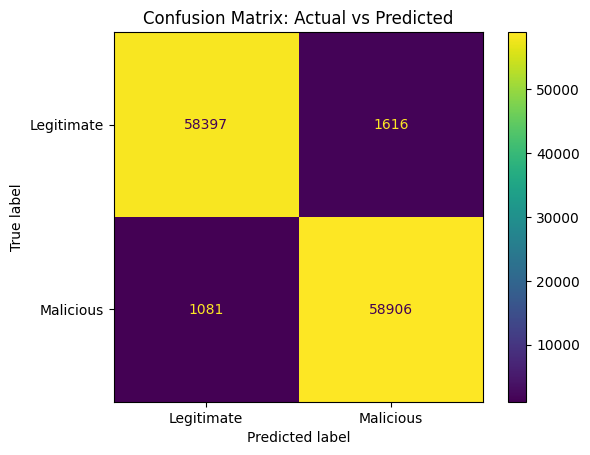

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Get predicted probabilities on the test set
y_pred_prob = model.predict(X_test)

# Convert probabilities to binary labels (0 = Legitimate, 1 = Malicious)
y_pred = (y_pred_prob > 0.5).astype(int).ravel()

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Legitimate", "Malicious"]
)
disp.plot()
plt.title("Confusion Matrix: Actual vs Predicted")
plt.show()

# Load and preprocess the TXT file (to test on new domains)

Next, you'll want to load your TXT file that contains the domains to be tested. We'll preprocess these domains the same way as the training data.

In [12]:
# Load the TXT file with domains to be tested
with open('test_sample.txt', 'r') as f:
    test_domains = f.readlines()

# Remove any extra whitespace or newline characters
test_domains = [domain.strip() for domain in test_domains]

# Convert domains to characters and then integers
test_domains_chars = [domain_to_chars(domain) for domain in test_domains]
test_domains_int = [ [char_to_int.get(char, 0) for char in domain] for domain in test_domains_chars ]  # 0 for unknown characters

# Pad the sequences to the same length as training data
test_domains_padded = pad_sequences(test_domains_int, maxlen=MAX_LENGTH)

# Predict using the trained LSTM model
predictions = model.predict(test_domains_padded)
predicted_labels = (predictions > 0.5).astype(int)  # Convert probabilities to binary labels

# Print the results
for domain, label in zip(test_domains, predicted_labels):
    print(f"Domain: {domain}, Predicted Label: {'Malicious' if label == 1 else 'Legitimate'}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step
Domain: aldeid.com, Predicted Label: Legitimate
Domain: google.com, Predicted Label: Legitimate
Domain: facebook.com, Predicted Label: Legitimate
Domain: baidu.com, Predicted Label: Legitimate
Domain: wikipedia.org, Predicted Label: Legitimate
Domain: qq.com, Predicted Label: Legitimate
Domain: binaryoptions.co.nz, Predicted Label: Legitimate
Domain: sextop.xxx, Predicted Label: Legitimate
Domain: freeaetemplates.net, Predicted Label: Legitimate
Domain: sitenizhazir.com, Predicted Label: Legitimate
Domain: webinarli.com, Predicted Label: Legitimate
Domain: freedomalliancenetwork.com, Predicted Label: Legitimate
Domain: uppobox.txt, Predicted Label: Legitimate
Domain: gentlehunger.net, Predicted Label: Malicious
Domain: heavytraining.net, Predicted Label: Malicious
Domain: gentletraining.net, Predicted Label: Malicious
Domain: heavystorm.net, Predicted Label: Malicious
Domain: gentlestorm.net, Predicted Label: Malicious
Domain: heavythrown.net, Pre

# Wrap up the notebook

Finally, after running the tests on the sample domains, you can evaluate the predictions and assess the performance of the model. You may also want to save the model for later use:

In [13]:
# Save the trained model for future use
model.save('dga_detection_model_local.keras')

In [14]:

# Print the model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (64, 75, 128)          │         9,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ (64, 75, 128)          │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (64, 100)              │        91,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (64, 1)                │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 302,369 (1.15 MB)

 Trainable params: 100,789 (393.71 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 201,580 (787.43 KB)